In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.metrics import accuracy_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [30]:
X_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_train_processed.pkl")
y_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_train_over.pkl")

In [31]:
X_train.columns

Index(['temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
       'date', 'train_serv_BELGORAIL', 'train_serv_EUROSTAR',
       'train_serv_EUROSTARFR', 'train_serv_SNCB/NMBS', 'train_serv_THI-FACT',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [32]:
X_train.drop(columns=["date"], inplace=True)

In [33]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    #max_depth=5,
    #max_features='auto',
    #n_jobs=-1,
    #class_weight='balanced'
)

K-fold cross validation

In [34]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [35]:
def compute_roc_auc(index):
    y_predict = clf.predict_proba(X_train.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train, clf.predict(X_train))
    return fpr, tpr, auc_score, accuracy

In [36]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

In [38]:
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy))
    fprs.append(fpr)
    tprs.append(tpr)

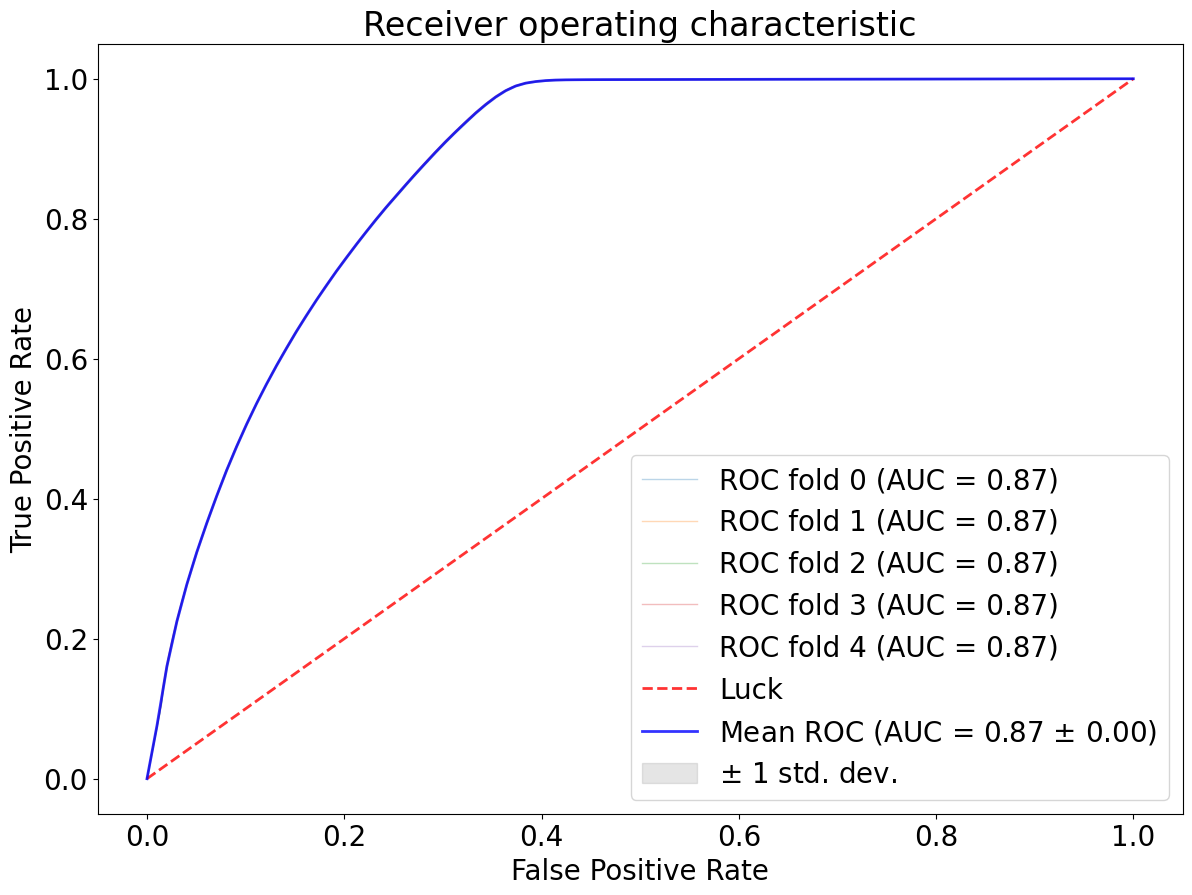

,AUC Train,AUC Test,Accuracy Train,Accuracy Test
0,0.917285,0.871602,0.831160,0.831160
1,0.917272,0.871868,0.831071,0.831071
2,0.917364,0.871207,0.831056,0.831056
3,0.917325,0.871690,0.831134,0.831134
4,0.917361,0.871375,0.831054,0.831054


In [39]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test', 'Accuracy Train', 'Accuracy Test'])

In [11]:
# save
joblib.dump(clf, "/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/Models/random_forest_v1.joblib")

['/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/Models/random_forest_v1.joblib']

In [12]:
# remove type of train
X_train_v2 = X_train[['temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

In [ ]:
def compute_roc_auc(index):
    y_predict = clf.predict_proba(X_train_v2.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v2, y_train), range(5)):
    clf.fit(X_train_v2.iloc[train], y_train.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])